In [2]:
import sys
sys.path.insert(0, '/Users/shiahlints/galvanize/FIXGITPROBLEM/booking-agent-ai')
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import find_nearest_venues as fnv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [3]:
train_events = pd.read_pickle('../data/train_events_df.p')
test_events = pd.read_pickle('../data/test_events_raw_df.p')
train_venues = pd.read_pickle('../data/train_venues_df.p')
artists = pd.read_pickle('../data/master_artists_df.p')


In [4]:
vf = fnv.Venue_Finder(train_venues)

In [5]:
number_of_samples = 50
samples = test_events.sample(number_of_samples)

In [6]:
def make_ALS_recomender(rank=17, regParam= 0.03, alpha=40):
    ratings_matrix = train_events[['artist_id', 'venue_id']].copy()
    ratings_matrix['event_counts'] = 1
    ratings_matrix = ratings_matrix.groupby(['artist_id', 'venue_id'], as_index = False)
    ratings_matrix = pd.DataFrame(ratings_matrix.count())
    #ratings_matrix['event_counts'] = 1
    sp_df = spark.createDataFrame(ratings_matrix)
    als_model = ALS(userCol='artist_id',
                    itemCol='venue_id',
                    ratingCol='event_counts',
                    nonnegative=True,
                    regParam=0.03,
                    rank=rank,
                    implicitPrefs=True,
                    alpha = 40)
    recomender = als_model.fit(sp_df)
    print('recomender_made')
    return recomender

In [7]:
#change this to get venue_id from sample

def make_thing_to_rate(artist_id, venue_id, nvenues):
    thing_to_rate = pd.DataFrame()
    thing_to_rate['venue_id'] = vf.get_nearest_venues_by_venue(venue_id, nvenues)['venue_id']
    thing_to_rate['artist_id'] = artist_id
    return thing_to_rate
def venue_not_in_top_n_recomendations(thing_to_rate, venue_id, n, recomender):
    spark_rate = spark.createDataFrame(thing_to_rate)
    predictions = recomender.transform(spark_rate)
    thing = predictions.dropna().sort('prediction',ascending=False).limit(n)
    result = thing.filter(thing.venue_id.like('%'+ str(venue_id)+ '%')).rdd.isEmpty()
    return result, thing

In [8]:
def test_recomender(recomender):
    new_venue = 0 
    ALS_sucesses = 0
    ALS_failures = 0
    number_venues_to_search = 100
    top_n_venues = 10
    for i, event in samples.iterrows():
        artist_id = event.artist_id
        venue_id = event.venue_id
        if venue_id not in train_venues.venue_id.values:
            new_venue += 1
            print ('new_venue')
            continue
        thing_to_rate = make_thing_to_rate(artist_id, venue_id, number_venues_to_search)
        result, thing = venue_not_in_top_n_recomendations(thing_to_rate, venue_id, top_n_venues, recomender)
        if result == False:
            ALS_sucesses += 1
        else:
            ALS_failures += 1
    sucess_rate = ALS_sucesses/(ALS_sucesses + ALS_failures)
    print ('als_rate ', ALS_sucesses/(ALS_sucesses + ALS_failures))
    return sucess_rate

In [9]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sc.defaultParallelism

4

fig, ax = plt.subplots()
x = list(range(20,150, 20))
for i in range(5):
    samples = test_events.sample(100)
    y = []
    for features in x:
        y.append(get_top_ten('genre', samples, features))
    plt.plot(x,y)
plt.title('Genre CountVectorizer Fitting')
plt.xlabel('Number of features in CountVectorizer')
plt.ylabel('Percent returned in top ten')
plt.savefig('CosineGenreModel.pdf')
plt.show()

In [10]:
ranks = [10,12,16,20,25,30,40]
models = []
for rank in ranks:
    models.append(make_ALS_recomender(rank=rank, regParam= .3, alpha=40))

recomender_made
recomender_made
recomender_made
recomender_made
recomender_made
recomender_made
recomender_made


new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.4
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.5333333333333333
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.5333333333333333
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.5333333333333333
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.5333333333333333
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.4666666666666667
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.5333333333333333
new_venue
als_rate  0.42105263157894735
new_venue
als_rate  0.47368421052631576
new_venue
als_rate  0.47368421052631576
new_venue
als_rate  0.47368421052631576
new_venue
als_rate  0.42105263157894735
new_venue
als_rate  0.47368421052631576
new_venue
als_rate  0.42105263157894735
new_venue
new_venue
new_venue
new_venue
als_rate  0.3125
new_venue
new_venue
new_venue
new_venue
als_rate  0.375
new_venue
new_venue
new_venue
new_venue
als_rate  0.375
new_venue
new

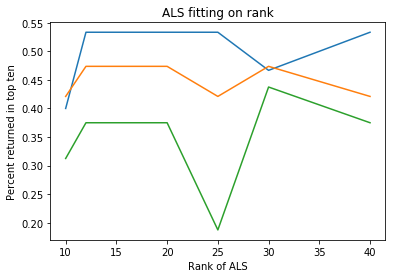

In [11]:
fig, ax = plt.subplots()
x = [10,12,16,20,25,30,40]
for i in range(3):
    samples = test_events.sample(20)
    y = []
    for model in models:
        y.append(test_recomender(model))
    plt.plot(x,y)
plt.title('ALS fitting on rank')
plt.xlabel('Rank of ALS')
plt.ylabel('Percent returned in top ten')
plt.savefig('ALS_rand.pdf')
plt.show() 

In [19]:
ranks = [10,12,16,20,25,30,40]
results = []
for Param in regParams:
    print(1)
    recomender = make_ALS_recomender(rank=20, regParam= Param, alpha=40)
    results.append(test_recomender(recomender))

1
recomender_made
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.45
1
recomender_made
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
new_venue
als_rate  0.45


In [80]:
no_bio = 0
no_genre = 0
new_venue = 0 
bio_sucesses = 0
bio_failures = 0
genre_sucesses = 0
genre_failures = 0
number_venues = 100
top_n = 10
for i, event in samples.iterrows():
    artist_id = event.artist_id
    venue_id = event.venue_id
    artist_bio = event.artist_bio
    artist_genre = event.artist_genre
    if venue_id not in train_venues.venue_id.values:
        new_venue += 1
        continue
    venues = vf.get_nearest_venues_by_venue(venue_id, number_venues)
    
    if artist_bio == None:
        no_bio += 1
    else:
        if venue_id in find_nearest_neighbor_by_bio(artist_bio, venues):
            bio_sucesses += 1
        else:
            bio_failures += 1
    if artist_genre == None:
        no_genre += 1
    else:
        if venue_id in find_nearest_neighbor_by_genre(artist_genre, venues):
            genre_sucesses += 1
        else:
            genre_failures += 1
    
print ('bio_rate ', bio_sucesses/(bio_sucesses + bio_failures))
print ('genre_rate ', genre_sucesses/(genre_sucesses + genre_failures))
 

bio_rate  0.7307692307692307
genre_rate  0.6153846153846154


In [74]:
1 - 99*98*97*96*95*94*93*92*91*90/(100**10)

0.43465914140023476

In [ ]:
df['event_counts'] = 1

In [323]:
test_events.shape

(6009, 29)

In [32]:
ratings_matrix = train_events[['artist_id', 'venue_id']].copy()

In [33]:
ratings_matrix['event_counts'] = 1

In [34]:
ratings_matrix = ratings_matrix.groupby(['artist_id', 'venue_id'], as_index = False)

In [35]:
ratings_matrix = pd.DataFrame(ratings_matrix.count())

In [36]:
ratings_matrix['event_counts'] = 1

In [37]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [38]:
sp_df = spark.createDataFrame(ratings_matrix)

In [39]:
sp_df.show()

+---------+--------+------------+
|artist_id|venue_id|event_counts|
+---------+--------+------------+
|        4|     339|           1|
|        7|    3047|           1|
|        7|    6003|           1|
|       12|    2378|           1|
|       12|    4198|           1|
|       12|    4695|           1|
|       12|    7023|           1|
|       12|    7392|           1|
|       16|    1309|           1|
|       16|    2904|           1|
|       16|    3167|           1|
|       16|    4172|           1|
|       16|    5823|           1|
|       16|    6287|           1|
|       18|    1497|           1|
|       18|    1639|           1|
|       18|    2378|           1|
|       18|    5981|           1|
|       18|    7370|           1|
|       21|    2515|           1|
+---------+--------+------------+
only showing top 20 rows



In [40]:
als_model = ALS(userCol='venue_id',
                itemCol='artist_id',
                ratingCol='event_counts',
                nonnegative=True,
                regParam=0.03,
                rank=17,
                implicitPrefs=True,
                alpha = 40)

In [41]:
recomender = als_model.fit(sp_df)

In [383]:
test_events.head(5)

,_id,artist_facebook,artist_id,artist_image,artist_name,artist_thumb,artist_url,artist_bio,artist_genre,home_town,...,event_url,venue_name,country,region,city,latitude,longitude,vn_original,venueidentifer,venue_id
57250,5b77a026482deb6355863728,,119355,https://s3.amazonaws.com/bit-photos/large/2300...,Mary Youngblood,https://s3.amazonaws.com/bit-photos/thumb/2300...,https://www.bandsintown.com/a/119355?came_from...,None,None,None,...,https://www.bandsintown.com/e/1010476361?app_i...,sofia,United States,CA,Sacramento,38.572569,-121.475330,The Sofia Tsakopoulos Center for The Arts,sofia Sacramento CA United States,6351
84585,5b7840e8482deb635586d0bc,https://www.facebook.com/echosofficial/,956212,https://s3.amazonaws.com/bit-photos/large/7869...,Echos,https://s3.amazonaws.com/bit-photos/thumb/7869...,https://www.bandsintown.com/a/956212?came_from...,Pre-order our self titled EP here: apple.co/2c...,"Metal, Rock, Punk, Progressive Metal, Post Har...","Portland, OR",...,https://www.bandsintown.com/e/1010770349?app_i...,oc fair event center,United States,CA,Costa Mesa,33.666608,-117.899463,OC Fair & Event Center,oc fair event center Costa Mesa CA United States,4754
17185,5b77487c482deb6355803612,,6486836,https://s3.amazonaws.com/bit-photos/large/8453...,Jordan Davis,https://s3.amazonaws.com/bit-photos/thumb/8453...,https://www.bandsintown.com/a/6486836?came_fro...,None,Rock,None,...,https://www.bandsintown.com/e/1010990079?app_i...,house of blues,United States,CA,San Diego,32.716534,-117.160253,House of Blues San Diego,house of blues San Diego CA United States,3167
95606,5b78592a482deb635586e76b,,4940989,https://s3.amazonaws.com/bit-photos/large/7772...,Joseph Solomon,https://s3.amazonaws.com/bit-photos/thumb/7772...,https://www.bandsintown.com/a/4940989?came_fro...,"Joseph Solomon is a poet, speaker, singer-song...",None,None,...,https://www.bandsintown.com/e/1010227883?app_i...,poets in autumn,United States,CA,Los Angeles,34.052222,-118.242778,POETS IN AUTUMN,poets in autumn Los Angeles CA United States,5250
20021,5b774e50482deb6355803f24,https://www.facebook.com/pages/FABULOUS-THUNDE...,46507,https://s3.amazonaws.com/bit-photos/large/6886...,The Fabulous Thunderbirds,https://s3.amazonaws.com/bit-photos/thumb/6886...,https://www.bandsintown.com/a/46507?came_from=...,Formed in 1974 by Kim Wilson and Jimmie Vaugha...,Blues,"Austin, Texas",...,https://www.bandsintown.com/e/1008350563?app_i...,everett theatre,United States,WA,Everett,47.986684,-122.201080,Historic Everett Theatre,everett theatre Everett WA United States,2195


In [384]:
train_venues[train_venues.venue_id == 2195]

,venueidentifer,venue_name,country,region,city,venue_genre,venue_bio,latitude,longitude,venue_id
1948,everett theatre Everett WA United States,everett theatre,United States,WA,Everett,"Folk All Styles Of Music Rock, Pop R&b/soul...","Singer, songwriter, producer and multi-instru...",47.986684,-122.20108,2195


In [13]:
#Train model

ratings_matrix = train_events[['artist_id', 'venue_id']].copy()
ratings_matrix['event_counts'] = 1
ratings_matrix = ratings_matrix.groupby(['artist_id', 'venue_id'], as_index = False)
ratings_matrix = pd.DataFrame(ratings_matrix.count())
#ratings_matrix['event_counts'] = 1
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sp_df = spark.createDataFrame(ratings_matrix)
als_model = ALS(userCol='venue_id',
                itemCol='artist_id',
                ratingCol='event_counts',
                nonnegative=True,
                regParam=0.03,
                rank=17,
                implicitPrefs=True,
                alpha = 40)
recomender = als_model.fit(sp_df)

In [37]:
#change this to get venue_id from sample

def make_artist_venue_to_rate(artist_id, venue_id):
    train_venues[train_venues.venue_id == venue_id]
    thing_to_rate = pd.DataFrame()
    thing_to_rate['venue_id'] = vf.get_nearest_venues_by_venue(veneu_id, 200)['venue_id']
    thing_to_rate['artist_id'] = artist_id
    return thing_to_rate
def check_spark(thing_to_rate):
    spark_rate = spark.createDataFrame(thing_to_rate)
    predictions = recomender.transform(spark_rate)
    thing = predictions.dropna().sort('prediction',ascending=False).limit(10)
    result = thing.filter(thing.venue_id.like('%4170%')).rdd.isEmpty()
    return result

In [398]:
nearest_venues = vf.get_nearest_venues_by_venue(2195, 200)['venue_id']

In [10]:
thing_to_rate = pd.DataFrame()

In [11]:
thing_to_rate['venue_id'] = vf.get_nearest_venues_by_venue(2195, 200)['venue_id']

In [12]:
thing_to_rate['artist_id'] = 46507

In [13]:
spark_rate = spark.createDataFrame(thing_to_rate)

In [25]:
predictions = recomender.transform(spark_rate)

In [27]:
thing =predictions.dropna().sort('prediction',ascending=False)
thing.filter(thing.venue_id.like('%4170%')).rdd.isEmpty()


False

In [34]:
thing = predictions.dropna().sort('prediction',ascending=False).limit(10)

thing.filter(thing.venue_id.like('%4170%')).rdd.isEmpty()

In [23]:
thing.filter(thing.venue_id.like('%4170%')).rdd.isEmpty()

False

In [418]:
thing1 = thing.limit(10)

In [20]:
thing1.show()

+--------+---------+-----------+
|venue_id|artist_id| prediction|
+--------+---------+-----------+
|    1276|    46507| 0.27925396|
|     317|    46507| 0.14863728|
|    1275|    46507| 0.13533342|
|     518|    46507| 0.12131372|
|    4170|    46507|0.115987405|
|     325|    46507|0.105548136|
|     324|    46507|0.105548136|
|     323|    46507|0.105548136|
|    2517|    46507| 0.10353198|
|    2574|    46507| 0.10068774|
+--------+---------+-----------+



In [437]:
thing1.filter(thing1.venue_id.like('%40%')).rdd.isEmpty()

True

In [435]:
thing1.df.rdd.isEmpty()

False

In [427]:
thing1.filter(($"venue_id" isin ("4170")).show()

SyntaxError: invalid syntax (<ipython-input-427-d36771b181eb>, line 1)

In [431]:
isIntContains:Boolean = \
dataframe.filter(col(venue_id).rlike("4170")).take(1).size>0



NameError: name 'dataframe' is not defined

In [405]:
predictionspd = thing.toPandas()

In [406]:
top_pridictions = predictionspd['venue_id'].values[0:20]

In [407]:
top_pridictions

array([4170, 1276, 1275, 6057,  598, 2026, 1771, 6415,  322, 6884, 1307,
       4251, 6262, 1514, 2195, 6812, 2203, 5460, 7101, 7099])

In [408]:
artists[artists['artist_id']== 46507]

,_id,bio,artist_facebook,genre,home_town,artist_id,artist_image,mbid,artist_name,artist_thumb,tour,tracker_count,upcoming_event_count,artist_url
1719,5b774e50482deb6355803f24,Formed in 1974 by Kim Wilson and Jimmie Vaugha...,https://www.facebook.com/pages/FABULOUS-THUNDE...,Blues,"Austin, Texas",46507,https://s3.amazonaws.com/bit-photos/large/6886...,835cbbdd-4a59-45a9-bf37-6d2050aec2a9,The Fabulous Thunderbirds,https://s3.amazonaws.com/bit-photos/thumb/6886...,"[{'offers': [{'type': 'Tickets', 'url': 'https...",36315,39,https://www.bandsintown.com/a/46507?came_from=...


In [409]:
train_venues[train_venues['venue_id'].isin(top_pridictions)]

,venueidentifer,venue_name,country,region,city,venue_genre,venue_bio,latitude,longitude,venue_id
280,angel of winds arena Everett WA United States,angel of winds arena,United States,WA,Everett,"Shock Rock, Rock, Rock N Roll Rock Hard Rock R...","In 1975, Alice Cooper joined forces with longt...",47.978900,-122.201858,322
529,beach rock music sports Suquamish WA United St...,beach rock music sports,United States,WA,Suquamish,"Alternative, Rock, Grunge Hip-hop, Rap, Hip Hop",,47.731389,-122.551111,598
1132,chateau ste michelle w steve miller band Woodi...,chateau ste michelle w steve miller band,United States,WA,Woodinville,"Rock, Classic Rock, Guitar Rock, Classic Rock,...",Grammy winner Peter Frampton remains one of th...,47.728770,-122.150003,1275
1133,chateau ste michelle winery Woodinville WA Uni...,chateau ste michelle winery,United States,WA,Woodinville,"Blues, Folk, Folk Rock, Alternative Blues Rock...",BEN HARPER & CHARLIE MUSSELWHITE BIOThere’s a ...,47.733422,-122.152337,1276
1161,chomp Southeast Redmond WA United States,chomp,United States,WA,Southeast Redmond,"Punk, Jazz",Official Skerik music page.,47.660908,-122.119648,1307
1333,conway muse Conway WA United States,conway muse,United States,WA,Conway,"Americana, Soul, Rock Guitar Virtuoso, Acousti...",Done:Aussie soul slinger Kara’s Grainger is kn...,48.340627,-122.343623,1514
1561,deify and emperidol special guests lucas tayne...,deify and emperidol special guests lucas tayne...,United States,WA,Seattle,Rockn Roll,"Deify is a rock band based in Seattle, WA comp...",47.668360,-122.376958,1771
1797,edmonds center for arts Edmonds WA United States,edmonds center for arts,United States,WA,Edmonds,"Contemporary Soul World Music Folk, R&b/soul, ...","Easy come, easy go; was the lesson two-time Em...",47.810785,-122.375613,2026
1948,everett theatre Everett WA United States,everett theatre,United States,WA,Everett,"Folk All Styles Of Music Rock, Pop R&b/soul...","Singer, songwriter, producer and multi-instru...",47.986684,-122.201080,2195
1956,evergreen state fairgrounds Monroe WA United S...,evergreen state fairgrounds,United States,WA,Monroe,Country,Randy Houser is a man refreshed. “I don’t know...,47.866410,-121.989027,2203
